In [3]:
# library imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from datetime import datetime

import warnings
warnings.filterwarnings("ignore")

from pydap.net import create_session
from pydap.client import open_url
import pydap
import gsw_xarray as gsw_xr
import cf_xarray

# local imports
from helperLibrary import subset, crop, profileLocationPlot


In [2]:
minimalProfileData = xr.open_dataset(
    "../data/ARGO_VortexProfiles/subsetProfiles/EasternTropicalPacific_densityMapped_minimal.nc"
)
minimalProfileData.info

<bound method Dataset.info of <xarray.Dataset> Size: 700MB
Dimensions:  (casts: 17195, levels: 2034)
Coordinates:
  * levels   (levels) float32 8kB 0.0 1.0 2.0 ... 2.031e+03 2.032e+03 2.033e+03
  * casts    (casts) int32 69kB 10366346 10366499 10366693 ... 21195581 21276866
    z        (casts, levels) float32 140MB ...
    lat      (casts) float32 69kB ...
    lon      (casts) float32 69kB ...
    time     (casts) datetime64[ns] 138kB ...
Data variables:
    SA       (casts, levels) float64 280MB ...
    sigma0   (casts, levels) float64 280MB ...
Attributes: (12/38)
    institution:                   National Centers for Environmental Informa...
    source:                        World Ocean Database
    references:                    World Ocean Database 2018. URL:http://data...
    title:                         World Ocean Database - Multi-cast file
    summary:                       Data for multiple casts from the World Oce...
    id:                            /nodc/data/OCLAB/O

In [3]:
minimalClimatology = xr.open_dataset(
    "../data/ARGO_RG2019_Climatology/subsetClimatology/RG_ArgoClim_ETP_densityMapped_minimal.nc"
)
minimalClimatology.info

<bound method Dataset.info of <xarray.Dataset> Size: 92MB
Dimensions:    (PRESSURE: 58, LATITUDE: 19, LONGITUDE: 23, TIME: 228)
Coordinates:
  * LONGITUDE  (LONGITUDE) float32 92B 245.5 246.5 247.5 ... 265.5 266.5 267.5
  * LATITUDE   (LATITUDE) float32 76B 5.5 6.5 7.5 8.5 ... 20.5 21.5 22.5 23.5
  * PRESSURE   (PRESSURE) float32 232B 2.5 10.0 20.0 ... 1.9e+03 1.975e+03
  * TIME       (TIME) datetime64[ns] 2kB 2004-01-01 2004-02-01 ... 2022-12-01
Data variables:
    SA         (PRESSURE, LATITUDE, LONGITUDE, TIME) float64 46MB ...
    sigma0     (PRESSURE, LATITUDE, LONGITUDE, TIME) float64 46MB ...>

In [40]:
# Interpolate climatology to profile locations
profileLocationClimatology = minimalClimatology[['SA', 'sigma0']].interp(
    LATITUDE=('casts', minimalProfileData['lat'].data),
    LONGITUDE=('casts', (minimalProfileData['lon'].data + 360) % 360),
    kwargs={'fill_value': None}
)

In [41]:
profileLocationClimatology['casts'] = ("casts", minimalProfileData['casts'].data)

In [44]:
missingInterpolationCasts = profileLocationClimatology['casts'].data[
    np.isnan(profileLocationClimatology['SA'].data)[0,:,0]
]

In [47]:
minimalProfileData

<xarray.Dataset> Size: 700MB
Dimensions:  (casts: 17195, levels: 2034)
Coordinates:
  * levels   (levels) float32 8kB 0.0 1.0 2.0 ... 2.031e+03 2.032e+03 2.033e+03
  * casts    (casts) int32 69kB 10366346 10366499 10366693 ... 21195581 21276866
    z        (casts, levels) float32 140MB ...
    lat      (casts) float32 69kB 14.49 7.801 7.035 6.934 ... 23.15 6.02 6.262
    lon      (casts) float32 69kB -112.9 -104.0 -101.8 ... -110.3 -100.9 -114.7
    time     (casts) datetime64[ns] 138kB ...
Data variables:
    SA       (casts, levels) float64 280MB ...
    sigma0   (casts, levels) float64 280MB nan nan nan 21.36 ... nan nan nan nan
Attributes: (12/38)
    institution:                   National Centers for Environmental Informa...
    source:                        World Ocean Database
    references:                    World Ocean Database 2018. URL:http://data...
    title:                         World Ocean Database - Multi-cast file
    summary:                       Data for multiple casts from the World Oce...
    id:                            /nodc/data/OCLAB/OCL/retrieval/monthlies/w...
    ...                            ...
    history:                       
    license:                       
    standard_name_vocabulary:      CF Standard Name Table v41
    featureType:                   Profile
    cdm_data_type:                 Profile
    Conventions:                   CF-1.6

In [78]:
castSA.data[:10]
castSigma0.data[:10]

array([21.91059756, 21.91324095, 21.916055  , 21.91887489, 21.92779776,
               nan,         nan, 25.30484661, 25.61194034, 25.92706246])

In [115]:
salinityAnomaly = minimalProfileData.copy()
salinityAnomaly['SA_anomaly'] = xr.DataArray(
    np.full_like(minimalProfileData['SA'].data, np.nan),
    dims=minimalProfileData['SA'].dims,
    coords=minimalProfileData['SA'].coords
)
salinityAnomaly['SA_climatology'] = xr.DataArray(
    np.full_like(minimalProfileData['SA'].data, np.nan),
    dims=minimalProfileData['SA'].dims,
    coords=minimalProfileData['SA'].coords
)

In [ ]:
salinityAnomaly.drop_vars(['SA', 'z'])

<xarray.Dataset> Size: 560MB
Dimensions:         (levels: 2034, casts: 17195)
Coordinates:
  * levels          (levels) float32 8kB 0.0 1.0 2.0 ... 2.032e+03 2.033e+03
  * casts           (casts) int32 69kB 10366346 10366499 ... 21195581 21276866
    lat             (casts) float32 69kB 14.49 7.801 7.035 ... 23.15 6.02 6.262
    lon             (casts) float32 69kB -112.9 -104.0 -101.8 ... -100.9 -114.7
    time            (casts) datetime64[ns] 138kB 2004-01-05T14:43:07.500000 ....
Data variables:
    SA_anomaly      (casts, levels) float64 280MB nan nan nan ... nan nan nan
    SA_climatology  (casts, levels) float64 280MB nan nan nan ... nan nan nan
Attributes: (12/38)
    institution:                   National Centers for Environmental Informa...
    source:                        World Ocean Database
    references:                    World Ocean Database 2018. URL:http://data...
    title:                         World Ocean Database - Multi-cast file
    summary:                       Data for multiple casts from the World Oce...
    id:                            /nodc/data/OCLAB/OCL/retrieval/monthlies/w...
    ...                            ...
    history:                       
    license:                       
    standard_name_vocabulary:      CF Standard Name Table v41
    featureType:                   Profile
    cdm_data_type:                 Profile
    Conventions:                   CF-1.6

In [122]:
np.isin(cast, missingInterpolationCasts)

array(False)

In [127]:
profileLocationClimatology

<xarray.Dataset> Size: 4GB
Dimensions:    (PRESSURE: 58, casts: 17195, TIME: 228)
Coordinates:
  * PRESSURE   (PRESSURE) float32 232B 2.5 10.0 20.0 ... 1.9e+03 1.975e+03
  * TIME       (TIME) datetime64[ns] 2kB 2004-01-01 2004-02-01 ... 2022-12-01
    LATITUDE   (casts) float32 69kB 14.49 7.801 7.035 6.934 ... 23.15 6.02 6.262
    LONGITUDE  (casts) float32 69kB 247.1 256.0 258.2 ... 249.7 259.1 245.3
  * casts      (casts) int32 69kB 10366346 10366499 ... 21195581 21276866
Data variables:
    SA         (PRESSURE, casts, TIME) float64 2GB 33.46 33.72 ... 34.82 34.82
    sigma0     (PRESSURE, casts, TIME) float64 2GB 21.59 21.93 ... 27.69 27.69

In [126]:
for cast in profileLocationClimatology['casts'][:]:
    print(cast.values)

10366346
10366499
10366693
10366712
10367152
10367302
10367502
10367547
10367580
10367600
10367972
10368115
10368305
10368351
10368460
10368493
10368789
10368953
10369161
10369190
10369389
10369421
10369659
10369750
10369822
10370007
10370047
10370307
10370352
10370493
10370659
10370852
10370864
10371211
10529151
10371349
10371412
10371521
10371686
10371732
10372120
10372176
10372190
10372367
10372544
10372581
10373058
10373086
10373124
10373237
10373428
10373460
10373879
10373965
10373997
10374053
10374201
10374231
10374592
10374735
10374748
10374761
10374910
10374954
10375314
10375490
10375523
10375572
10375649
10375670
10375830
10375909
10376050
10376202
10376326
10376400
10376411
10376581
10376687
10376798
10376893
10377084
10377276
10377292
10377320
10377729
10377820
10377838
10377999
10378239
10378256
10378283
10378728
10378756
10378853
10378928
10379165
10379208
10379322
10379768
10379894
10379979
10380023
10380258
10380462
10380956
10381060
10381090
10381203
10381304
10381624
1

[nan nan nan ... nan nan nan]
[nan nan nan ... nan nan nan]
[nan nan nan ... nan nan nan]
[nan nan nan ... nan nan nan]
[nan nan nan ... nan nan nan]
[33.83488293 33.83846575 33.85024782 ...         nan         nan
         nan]
[33.83488293 33.83846575 33.85024782 ...         nan         nan
         nan]
[33.63573754 33.64032644 33.655417   ...         nan         nan
         nan]
[33.73531023 33.7393961  33.75283241 ...         nan         nan
         nan]
[33.45141821 33.45558841 33.46930207 ...         nan         nan
         nan]
[33.59336422 33.59749226 33.61106724 ...         nan         nan
         nan]
[33.47647273 33.47862823 33.48571657 ...         nan         nan
         nan]
[33.53491848 33.53806024 33.54839191 ...         nan         nan
         nan]
[33.28460681 33.28751542 33.29708032 ...         nan         nan
         nan]
[33.40976264 33.41278783 33.42273611 ...         nan         nan
         nan]
[33.19777929 33.20149764 33.21372538 ...         nan        

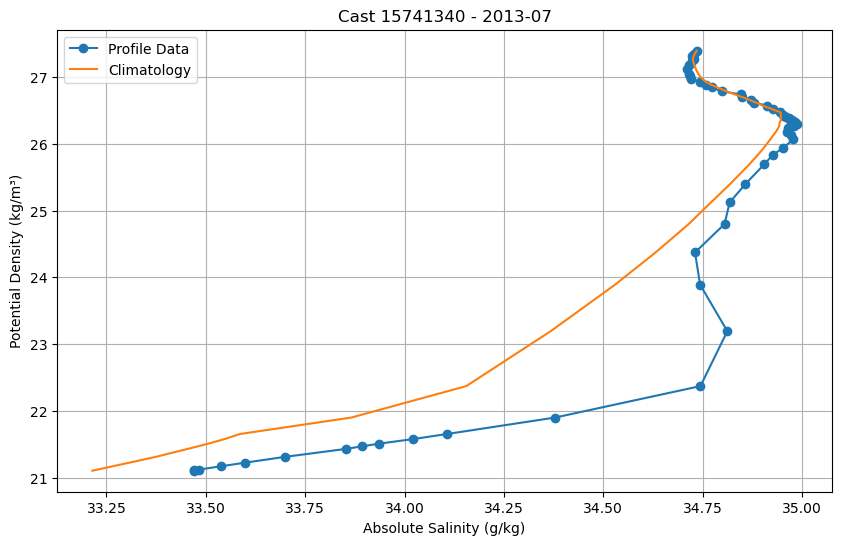

In [ ]:
casts = profileLocationClimatology['casts'][8472:8473]

for cast in casts:
    castSigma0 = minimalProfileData['sigma0'].sel(casts=cast)
    castSA = minimalProfileData['SA'].sel(casts=cast)
    castYear = minimalProfileData['time.year'].sel(casts=cast).data
    castMonth = minimalProfileData['time.month'].sel(casts=cast).data
    castClimatology = profileLocationClimatology.sel(
            casts=cast,
            TIME=slice(
                np.datetime64(f'{castYear}-{castMonth:02d}') -
                np.timedelta64(5, 'M'),
                np.datetime64(f'{castYear}-{castMonth:02d}') +
                np.timedelta64(6, 'M')
            )
        )
    
    plt.figure(figsize=(10, 6))
    plt.plot(
        castSA.data, castSigma0.data,
        label='Profile Data', marker='o', linestyle='-'
    )

    meanInterpolatedBackground = \
        np.full_like(castSA.data, np.nan)

    for time in castClimatology['TIME'].data:
        # Get the background field for the current time
        backgroundField = castClimatology.sel(TIME=time)

        # Interpolate the background field to the density surfaces
        # and accumulate the mean

        if np.isnan(meanInterpolatedBackground).all():
            meanInterpolatedBackground = np.interp(
                castSigma0.data,
                backgroundField['sigma0'].data,
                backgroundField['SA'].data,
                left=np.nan,  # Handle extrapolation
                right=np.nan   # Handle extrapolation
            )
        else:
            # Use np.nanmean to handle NaNs in the mean calculation
            stack = np.stack(
                (meanInterpolatedBackground,
                 np.interp(
                     castSigma0.data,
                     backgroundField['sigma0'].data,
                     backgroundField['SA'].data,
                     left=np.nan,  # Handle extrapolation
                     right=np.nan   # Handle extrapolation
                 )),
                axis=1
            )
            np.nanmean(
                stack, axis=1, out=meanInterpolatedBackground
            )
    plt.plot(
        meanInterpolatedBackground, castSigma0.data, linestyle='-',
        label=f'Climatology'
    )
    plt.title(f'Cast {cast.data} - {castYear}-{castMonth:02d}')
    plt.xlabel('Absolute Salinity (g/kg)')
    plt.ylabel('Potential Density (kg/m³)')
    plt.legend()
    plt.grid()
    plt.show()

In [91]:
# Create a numpy array to hold the mean interpolated background
interpolatedBackground = \
    np.full_like(castClimatology['SA'].data, np.nan)

interpolatedBackground[:,12]

IndexError: index 12 is out of bounds for axis 1 with size 12

In [118]:
salinityAnomaly['SA_anomaly'].loc[dict(casts=cast)] = (
            castSA - meanInterpolatedBackground
        )
salinityAnomaly['SA_anomaly'].loc[dict(casts=cast)].data[:10]

array([0.25674647, 0.25346261, 0.25519911, 0.27170793, 0.29094212,
       0.32542249, 0.39705917, 0.41327135, 0.42958319, 0.47395752])

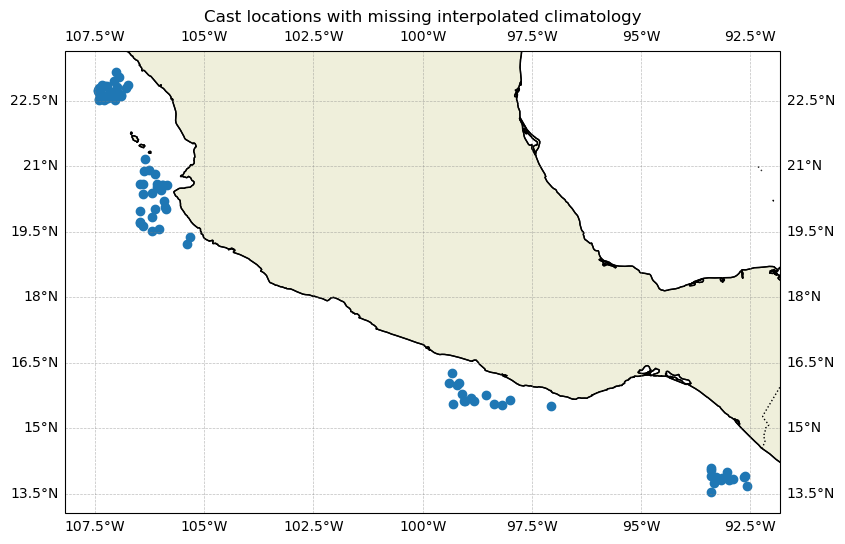

In [204]:
data = minimalProfileData['casts'][np.argwhere(interpolatedSalinity[-1,:,-10].isnull().values)[:,0]]
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})
scatter = ax.scatter(
    data['lon'], data['lat'], cmap='viridis'
)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.LAND, edgecolor='black')
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.set_title('Cast locations with missing interpolated climatology')
ax.gridlines(
    draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--'
)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.savefig('missing_salinity_casts.png', dpi=300, bbox_inches='tight')

In [4]:
salinityAnomalies = xr.open_dataset(
    "../data/ARGO_VortexProfiles/subsetProfiles/EasternTropicalPacific_anomalies.nc"
)

In [13]:
lat_range = (14, 15.5)
lon_range = (-112, -110.5)

sampleBinAnomalies = subset(
    salinityAnomalies,
    lat_range=lat_range,
    lon_range=lon_range,
    var_names=['lat', 'lon', 'time']
)

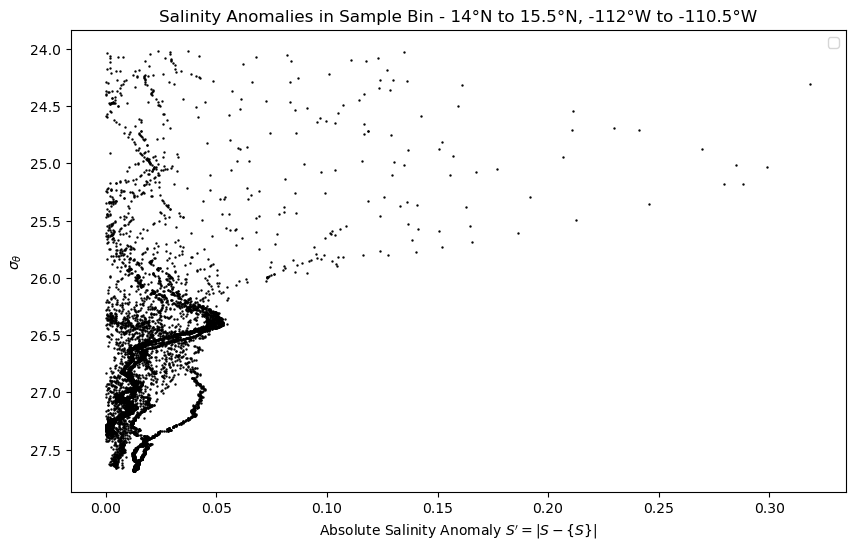

In [ ]:
plottingStuff = sampleBinAnomalies.where(sampleBinAnomalies['sigma0'] > 24)
plt.figure(figsize=(10, 6))
plt.scatter(
    np.abs(plottingStuff['SA_anomaly'].data), plottingStuff['sigma0'].data,
    linestyle='-', color='black', s=0.5
)
plt.xlabel(r'Absolute Salinity Anomaly $|S^\prime| = |S - \{S\}|$')
plt.ylabel(r'$\sigma_\theta$')
plt.title(f'Salinity Anomalies in Sample Bin - {lat_range[0]}°N to {lat_range[1]}°N, {lon_range[0]}°W to {lon_range[1]}°W')
# Reverse y-axis
plt.gca().invert_yaxis()
plt.legend()
plt.show()

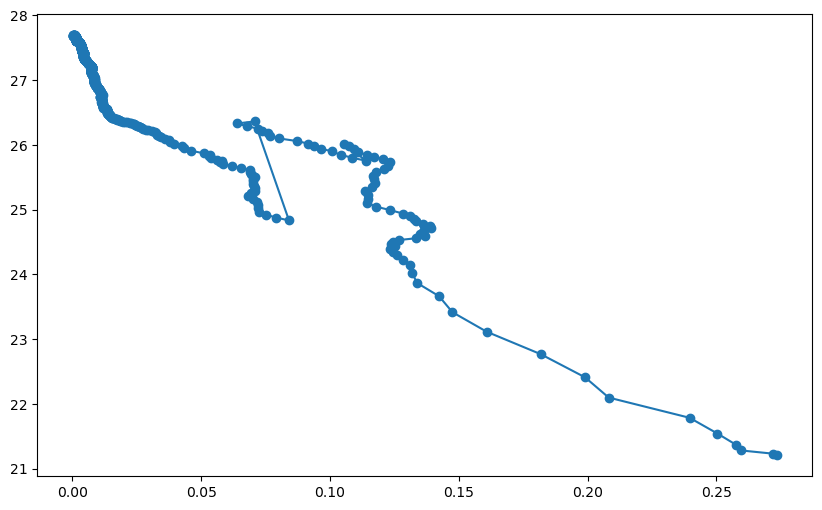

In [171]:
anomaly_avg = np.sqrt(np.nanmean(sampleBinAnomalies['SA_anomaly']**2, axis=0))
plt.figure(figsize=(10, 6))
plt.plot(
    anomaly_avg, np.nanmean(sampleBinAnomalies['sigma0'].data, axis=0),
    marker='o', linestyle='-'
)

In [36]:
uvel_url = 'http://apdrc.soest.hawaii.edu:80/dods/public_data/ECCO/ECCO2/cube92_daily/uvel'
vvel_url = 'http://apdrc.soest.hawaii.edu:80/dods/public_data/ECCO/ECCO2/cube92_daily/vvel'
theta_url = 'http://apdrc.soest.hawaii.edu:80/dods/public_data/ECCO/ECCO2/cube92_daily/theta'
salt_url = 'http://apdrc.soest.hawaii.edu:80/dods/public_data/ECCO/ECCO2/cube92_daily/salt'
ECCO2_uvel = xr.open_dataset(
    uvel_url,
    engine='pydap'
)
ECCO2_vvel = xr.open_dataset(
    vvel_url,
    engine='pydap'
)
ECCO2_theta = xr.open_dataset(
    theta_url,
    engine='pydap'
)
ECCO2_salt = xr.open_dataset(
    salt_url,
    engine='pydap'
)

In [49]:
ECCO2_uvel = ECCO2_uvel.sel(
    lat=slice(5, 23.75),
    lon=slice(245, 267.5),
    time=slice(np.datetime64('2004-01-01'), np.datetime64('2022-12-31')),
    drop=True
)

In [50]:
ECCO2_vvel = ECCO2_vvel.sel(
    lat=slice(5, 23.75),
    lon=slice(245, 267.5),
    time=slice(np.datetime64('2004-01-01'), np.datetime64('2022-12-31')),
    drop=True
)

In [51]:
ECCO2velocities = xr.merge(
    [ECCO2_uvel, ECCO2_vvel]
)

In [52]:
ECCO2velocities

<xarray.Dataset> Size: 19GB
Dimensions:  (time: 6940, lev: 50, lat: 75, lon: 90)
Coordinates:
  * time     (time) datetime64[ns] 56kB 2004-01-01 2004-01-02 ... 2022-12-31
  * lev      (lev) float64 400B 5.0 15.0 25.0 ... 5.039e+03 5.461e+03 5.906e+03
  * lat      (lat) float64 600B 5.125 5.375 5.625 5.875 ... 23.12 23.38 23.62
  * lon      (lon) float64 720B 245.1 245.4 245.6 245.9 ... 266.9 267.1 267.4
Data variables:
    uvel     (time, lev, lat, lon) float32 9GB ...
    vvel     (time, lev, lat, lon) float32 9GB ...
Attributes:
    title:          ECCO2 cube92 daily average  Zonal Velocity
    Conventions:    ['COARDS', 'GrADS']
    dataType:       Grid
    documentation:  http://apdrc.soest.hawaii.edu/datadoc/ecco2_cube92.php
    history:        Sun Jun 22 10:36:17 HST 2025 : imported by GrADS Data Ser...

In [54]:
ECCO2velocities = ECCO2velocities.where(
    (ECCO2velocities['lat'] <= 18) |
    (ECCO2velocities['lon'] <= 240), drop=True
)

ConnectionError: HTTPConnectionPool(host='apdrc.soest.hawaii.edu', port=80): Read timed out.